In [22]:
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt
from Simplex.noise import OpenSimplex
import GaussianDiffusion
from patchify import patchify, unpatchify, batch_patchify

In [23]:
def generate_simplex_4_patch_noise(x, 
                            t, 
                            octave=10, 
                            persistence=0.8, 
                            frequency=128,
                            channels = 1,
                            patch_size = 16
                           ):
    noise = torch.empty(x.shape)
#     .to(x.device)    
    t = t.unsqueeze(1)

    for i in range(x.shape[0]):
        x_patch = patchify(x[i].numpy(), (channels, patch_size, patch_size), step = patch_size)
        temp = np.empty(x_patch.shape)
        for i in range(x_patch.shape[0]):
            for j in range(x_patch.shape[1]):
                for k in range(x_patch.shape[2]):
                    
                    seed = np.random.randint(-10000000, 10000000)
                    
                    Simplex_instance = OpenSimplex(seed = seed)
                    
                    temp[i, j, k, ...] = torch.from_numpy(
                        Simplex_instance.rand_4d_fixed_T_octaves(
                            shape = x_patch.shape[-3:], 
                            T = t.detach().cpu().numpy()[i], 
                            scale = 0.1, 
                            octaves = octave,
                            persistence = persistence,
                            frequency = frequency
                        )
                    )
        x_unpatch = unpatchify(temp, x.numpy().shape[1:])
        noise[i, ...] = torch.from_numpy(x_unpatch).to(x.device)

    return noise

In [24]:
def generate_simplex_4noise(x, 
                            t, 
                            octave=10, 
                            persistence=0.8, 
                            frequency=128
                           ):
    noise = torch.empty(x.shape).to(x.device)    
#     print("x", x.shape)
#     print("noise", noise.shape)
    t = t.unsqueeze(1)
#     print("octave", octave)
    for i in range(x.shape[0]):
        seed = np.random.randint(-10000000, 10000000)
        Simplex_instance = OpenSimplex(seed = seed)
        noise[i, ...] = torch.from_numpy(
                    Simplex_instance.rand_4d_fixed_T_octaves(
                        shape = x.shape[1:], 
                        T = t.detach().cpu().numpy()[i], 
                        scale = 0.1, 
                        octaves = octave,
                        persistence = persistence,
                        frequency = frequency
                    )
                ).to(x.device)
#         print(t.detach().cpu().numpy()[i])
#         .repeat(x.shape[0], 1, 1, 1)
#     print(noise.shape)
#     noise = (noise - torch.min(noise)) / (torch.max(noise) - torch.min(noise))
    return noise

In [45]:
def generate_mixed_noise(x, 
                            t, 
                            octave=10, 
                            persistence=0.8, 
                            frequency=128,
                            time_step = 1000
                           ):
    noise = torch.empty(x.shape).to(x.device)    
#     print("x", x.shape)
#     print("noise", noise.shape)
    t = t.unsqueeze(1)
#     print("octave", octave)
    for i in range(x.shape[0]):
        wt = t[i]/time_step
        seed = np.random.randint(-10000000, 10000000)
        Simplex_instance = OpenSimplex(seed = seed)
        simplex = torch.from_numpy(
                    Simplex_instance.rand_4d_fixed_T_octaves(
                        shape = x.shape[1:], 
                        T = t.detach().cpu().numpy()[i], 
                        scale = 0.1, 
                        octaves = octave,
                        persistence = persistence,
                        frequency = frequency
                    )
                ).to(x.device)
        gauss = torch.randn_like(x[i])
        noise[i, ...] = (1-wt)*simplex + wt*gauss
    return noise

In [46]:
# x = torch.rand(1, 1, 256, 256)
octave=2
persistence=0.8
frequency = 16
num_timesteps = 1000
in_channels = 1

In [47]:
x = torch.rand(10, in_channels, 256, 256)
t = torch.randint(0, num_timesteps, (x.shape[0],), device=x.device)

In [48]:
simplexnoise = generate_mixed_noise(x, t)

In [49]:
simplexnoise.shape

torch.Size([10, 1, 256, 256])

In [28]:
gauss = torch.randn_like(x)

In [29]:
gauss.shape

torch.Size([10, 1, 256, 256])

In [42]:
x[1].shape

torch.Size([1, 256, 256])

In [19]:
simplexnoise.shape

torch.Size([10, 1, 256, 256])

In [20]:
t

tensor([968, 959, 851, 301, 249, 644, 144, 125, 338, 650])

In [101]:
# noiice = patch_noise(x_test, t, noise_fun = GaussianDiffusion.generate_simplex_4noise, patch_size = 16)

In [50]:
def plot_tensor(tensor):
    array = tensor.numpy()
    array = array.transpose(1, 2, 0)
    plt.imshow(array, cmap = 'gray')
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

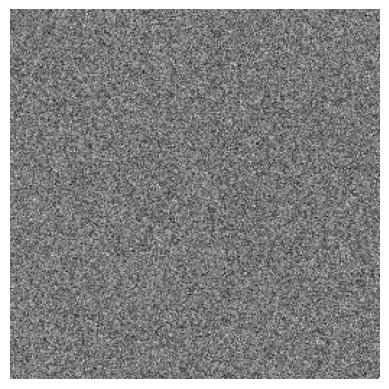

In [58]:
plot_tensor(simplexnoise[5])

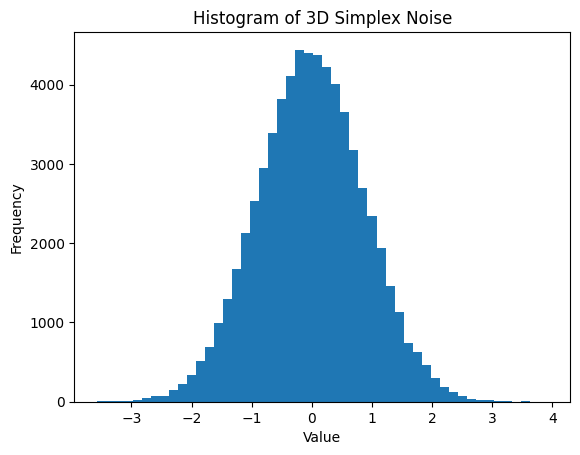

In [64]:
# Generate random noise
noise = simplexnoise[0].flatten().numpy()
# Plot the histogram
plt.hist(noise, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3D Simplex Noise')
plt.show()

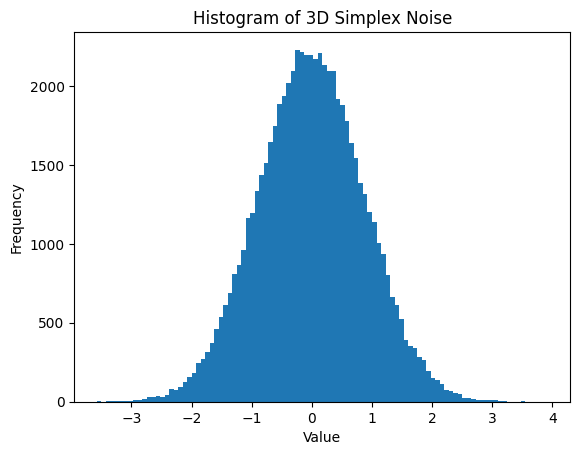

In [62]:
# Generate random noise
noise = simplexnoise[0].flatten().numpy()
# Plot the histogram
plt.hist(noise, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3D Simplex Noise')
plt.show()

In [63]:
import numpy as np
from scipy.stats import kurtosis, skew

# x = np.random.normal(0, 1, 100000)   # create random values based on a normal distribution

print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(noise, fisher=False) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(noise) ))

excess kurtosis of normal distribution (should be 0): 3.0058659572533593
skewness of normal distribution (should be 0): 0.0029069611912968672
